# Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import os
from pyfuncs import *

startdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/analysis/'

# Read in selected data, combine into one large dataframe

In [3]:
runDates = ['20210803_1','20210816','20210817_1','20210818_1']

os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)

# Look for ways to split by upstroke and downstroke

Why not split upstroke and downstroke (or, at least, split the wingstroke into halves) by taking the other points where the hilbert transform angle flips across zero?

In [52]:
dt = df.loc[(df.date=='20210817_1') & (df.pulse==1),]

plt.plot(dt.Time, dt.mx)
plt.plot(dt.Time, np.angle(hilbert(dt.fz))/10)
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
# plt.xlim((-18.6,-18.4))

Using matplotlib backend: MacOSX


# Estimating "actual pitch" from pitch torque

I am slightly suspicious of this, partially because I don't trust that we've actually transformed FT matrix to be at the real COM, especially going from individual to individual. How much would that throw off this analysis? Do we have stronger ways to verify?

Right now values don't really make sense; Way too large. Need to verify that torques are properly in Nmm. Also worth noting; bias offsets are applied *after* transformation matrix, and taken from an empty stand. There **will** be torque DC offsets with quiescent moth; need to pull those out, account for in bias?

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


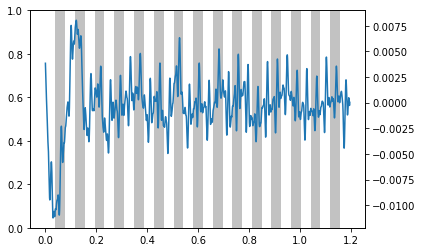

In [89]:
dt = df.loc[(df.date=='20210817_1') & (df.pulse==1),]
dt.Time -= dt.Time.iloc[0]

fsamp = 10000
Iyy = 266.7/1000/(1000**2) # gmm^2 to kg m^2

plt.figure()
time = dt.Time.to_numpy()
mx = dt.mx
theta = cumtrapz(cumtrapz(mx/1000**2/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
plt.plot(time, dt.mx)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time[1:-1], butterfilt(theta, 5, fsamp, order=5, bandtype='high'))

/var/folders/wk/44b_fwgs06q9gfdjtfs124640000gp/T/ipykernel_68822/1142113443.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,B)


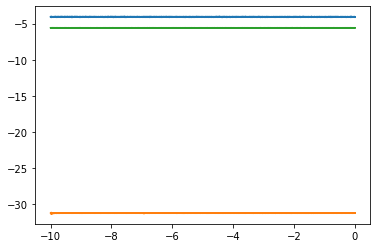

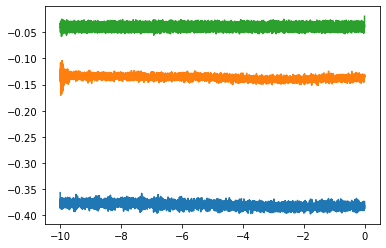

In [24]:
date = '20210816_1'
trial = '003'

hpfCutoff = 70,
lpfCutoff = 500,
readFrom = 'dropbox'

# Dumb hard-coded info
channelsEMG = ['LDVM','LDLM','RDLM','RDVM']
# Read empty data for FT
biasdata, colnames, fsamp = readMatFile(date, 'empty', doFT=True, readFrom=readFrom, useAltTransform=False)
bias = np.zeros((6,1))
for i in range(6):
    bias[i] = np.mean(biasdata[colnames[i+1]])
# Read actual data
emg, emgnames, fsamp = readMatFile(date, trial, doFT=False, readFrom=readFrom)
ftd, ftdnames, _     = readMatFile(date, trial, bias=bias, doFT=True, readFrom=readFrom, useAltTransform=False)
# Filter data
for name in channelsEMG: # Filter EMG
    emg[name] = butterfilt(emg[name], hpfCutoff, fsamp, order=4, bandtype='high')
for name in ftdnames: # Filter FT
    ftd[name] = butterfilt(ftd[name], lpfCutoff, fsamp, order=4, bandtype='low')
# Remove stim periods from emg channels
inds = emg['stim'] > 3
for name in channelsEMG:
    emg[name][inds] = np.nan


# Get mean forces
means = np.array([np.mean(ftd[ftdnames[i+1]]) for i in range(6)])
# Set up A and B matrices for least squares
A = np.zeros((3,9))
B = means[3:]
A[0,0:3] = means[0:3]
A[1,3:6] = means[0:3]
A[2,6:9] = means[0:3]
# Get values of transformation matrix from least squares
x = np.linalg.lstsq(A,B)

# Use those values to make new transform, apply and plot result
newtrans = np.array([
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0],
    [*x[0][0:3], 1, 0, 0],
    [*x[0][3:6], 0, 1, 0],
    [*x[0][6:9], 0, 0, 1]
    ])

# Read in again, with new transform
ft, _, _ = readMatFile(date, trial, bias=bias, doFT=True, readFrom=readFrom, useAltTransform=True, altTransform=newtrans)
# Filter data
for name in ftdnames: # Filter FT
    ftd[name] = butterfilt(ftd[name], lpfCutoff, fsamp, order=4, bandtype='low')

plt.figure()
for i in range(3):
    plt.plot(ft['Time'], ft[ftdnames[i+4]])
plt.figure()
for i in range(3):
    plt.plot(ftd['Time'], ftd[ftdnames[i+4]])


The above doesn't work because of the extra bits: The calibration matrix, and the biasing. Will have to carefully go through and determine how all of those interact with least squares to get a working final product